# Looking at selected genome-microbiome-interactions

After we fitted the interactions in the training set let's now look at some of the interactions in more detail.

In [1]:
from pyplink import PyPlink
import pandas as pd
from rich.progress import track
import arivale_data_interface as adi
from utils import rsid2gene, enrichment
import warnings
warnings.simplefilter("ignore")

metabolites = pd.read_csv("data/metabolites_residuals.csv")
raw = pd.read_csv("data/metabolites_raw.csv")
microbes = pd.read_csv("data/genera_clr_filtered.csv")
genotypes = PyPlink("input_bed/all_chr/all_genomes_09112019_all_chr")
genome_ids = genotypes.get_fam().iid.values

interactions = pd.read_csv("data/interaction_results_annotated.csv")

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/arivale_data_interface/snapshots_interface.py:31: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  DEPRECATIONS = yaml.load(in_yaml)
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


## Enrichment analyses

Let's look what features show an enrichment in interactions first.

In [2]:
interactions["genes"] = interactions.genes.str.split(",").str[0]

pathway_enr = enrichment(interactions, 0.05, "SUB_PATHWAY", figsize=(3, 5))
microbe_enr = enrichment(interactions, 0.05, "family", figsize=(3, 4))
gene_enr = enrichment(interactions, 0.05, "genes", figsize=(3, 7))

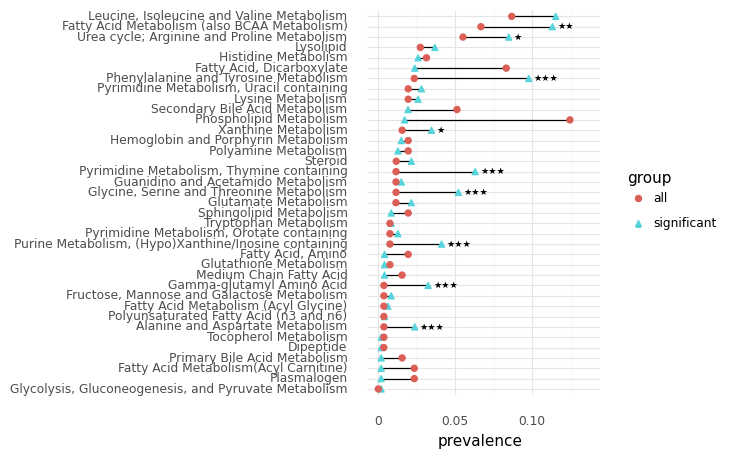

<ggplot: (8776147731797)>

In [39]:
pathway_enr[1].save("figures/enriched_pathways.pdf", width=3, height=6)
pathway_enr[1]

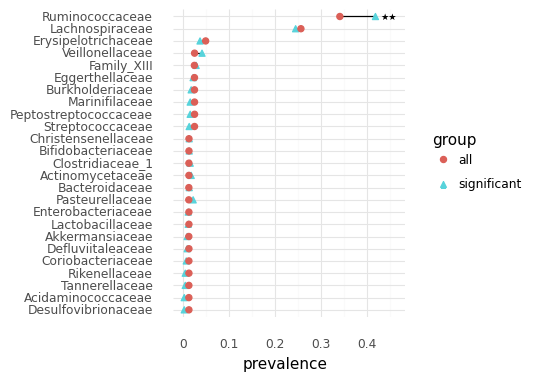

<ggplot: (8776147758556)>

In [40]:
microbe_enr[1].save("figures/enriched_microbes.pdf", width=3, height=4)
microbe_enr[1]

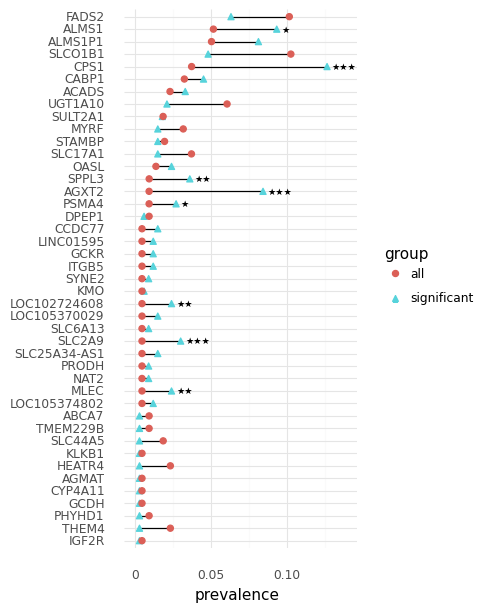

<ggplot: (8776149408130)>

In [5]:
gene_enr[1].save("figures/enriched_genes.pdf", width=3, height=7)
gene_enr[1]

## Look at specficic interactions

Now we look at some interesting combinations. As a post-hoc test for genome-microbiome interactions we will plot the metabolite vs. microbe abundances as a function of the SNP alleles. We will do this for the training data, validation data, and non-confounder-corrected training data. 

In [19]:
from plotnine import *
theme_set(theme_minimal())
from scipy.stats import pearsonr, spearmanr

def plot_interaction(df, metabolites, prefix=""):
    """Plot interactions for a subset of significant hits."""
    mic = microbes[["stool_sample_id", df.taxon]].rename(columns={df.taxon: "microbe"})
    mets = pd.merge(metabolites[["stool_sample_id", "genome_id", df.metabolite]], mic, on="stool_sample_id").rename(columns={df.metabolite: "metabolite"})
    geno = pd.Series(genotypes.get_acgt_geno_marker(df.SNP), index=genome_ids)
    plots = [None] * 3
    bim = genotypes.get_bim()
    minor = bim.loc[df.SNP, 'a1']
    major = bim.loc[df.SNP, 'a2']
    alleles = [major * 2, minor + major, minor * 2]
    alleles_nice = [f"{df.genes if not pd.isnull(df.genes) else 'chr' + str(df.CHR)} {df.rsid} = {a}" for a in alleles]
    mets["allele"] = pd.Categorical(geno[mets.genome_id].values, alleles)
    mets["label"] = pd.Categorical([f"{df.genes if not pd.isnull(df.genes) else 'chr' + str(df.CHR)} {df.rsid} = {a}" for a in mets.allele], alleles_nice)

    stats = mets.dropna().groupby("label").apply(lambda df: pd.Series(spearmanr(df.microbe, df.metabolite), index=["r", "p"])).reset_index()
    stats["x"] = mets.microbe.max()
    stats["y"] = mets.metabolite.min() - 0.5
    stats["text"] = [f"ρ={row.r:.2f}, p={row.p:.2g}" for _, row in stats.iterrows()]

    pl = (
        ggplot(mets.dropna(subset=["allele"]))
        + aes(x="microbe", y="metabolite") 
        + geom_point(size=3, alpha=0.5, color="black", stroke=0)
        + stat_smooth(method="lm", color="blue")
        + geom_text(data=stats, mapping=aes(label="text", x="x", y="y"), color="black", ha="right", size=12)
        + labs(x = f"{df.genus} [CLR-transformed]", y=f"{df.BIOCHEMICAL_NAME} [a.u.]")
        + guides(color = None)
        + facet_wrap("~ label")
        + theme(strip_text_x = element_text(size = 11))
    )
    return pl

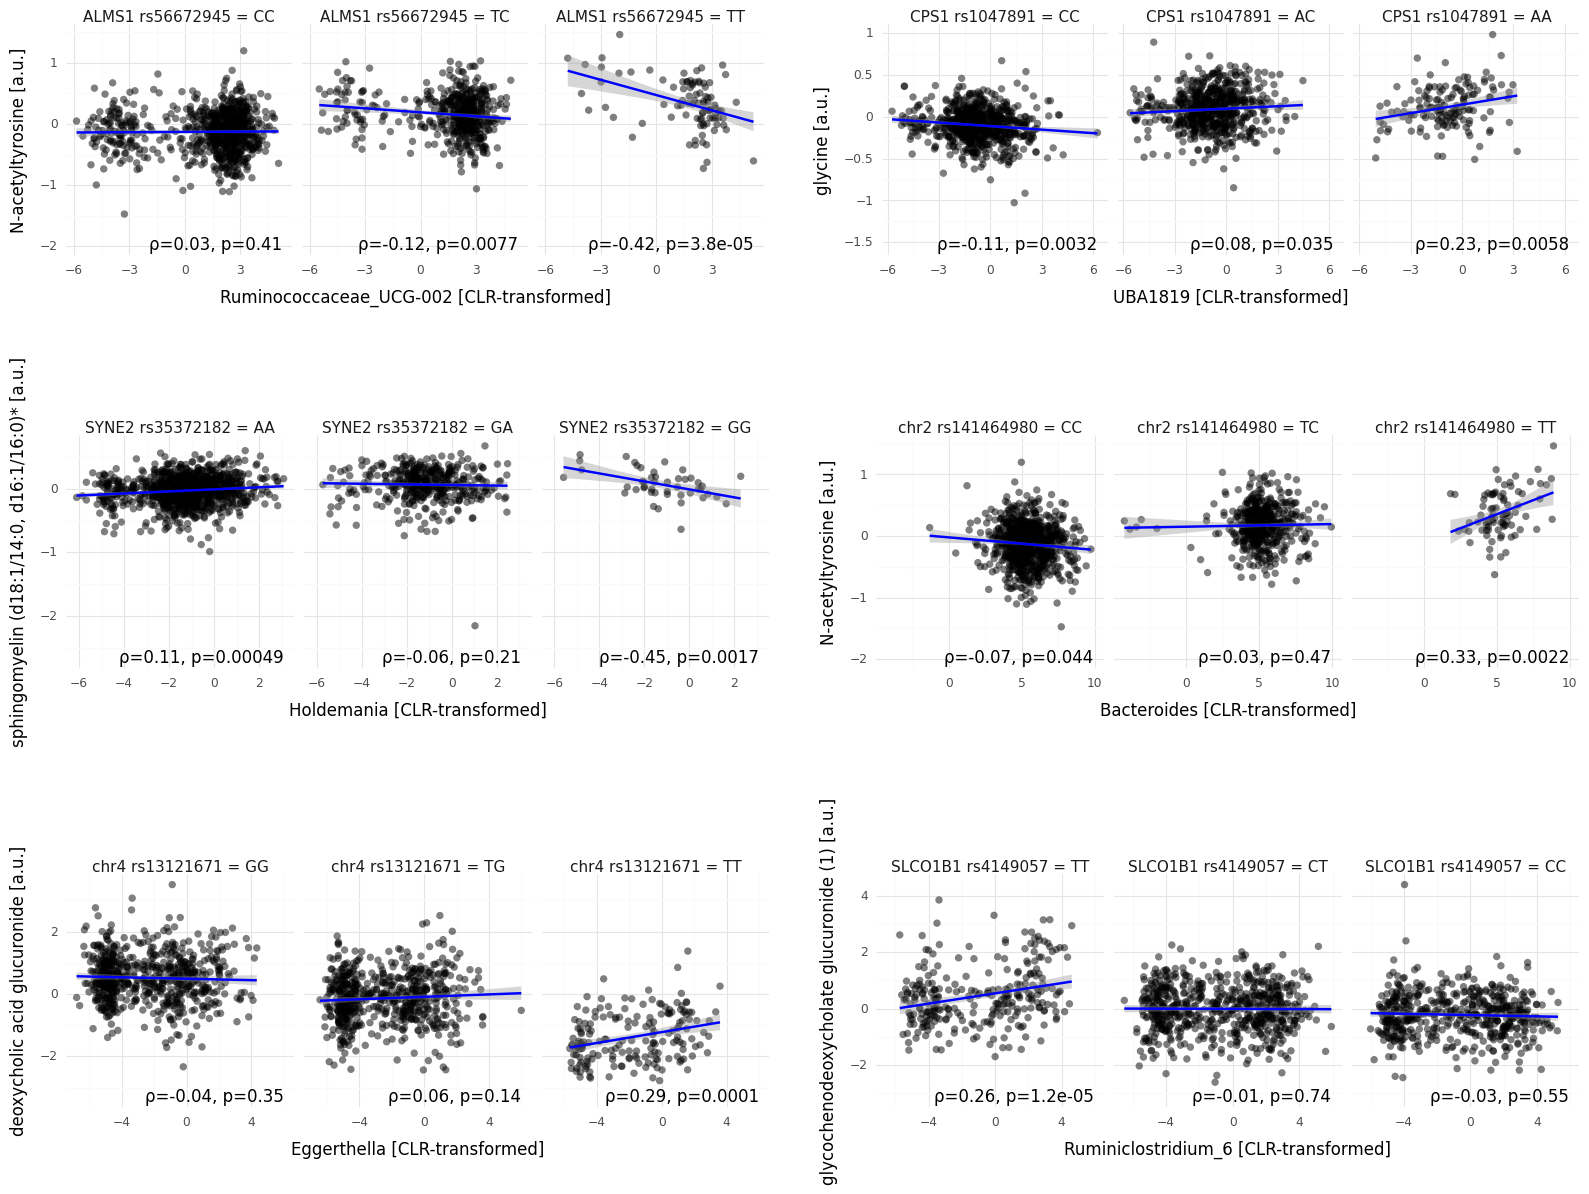

In [33]:
import patchworklib as pw

size = (9, 3)
adj = []

for i in [0, 1, 11, 14]:
    adj.append(pw.load_ggplot(plot_interaction(interactions.iloc[i], metabolites), figsize=size))

pl = plot_interaction(interactions[(interactions.genus == "Eggerthella") & (interactions.BIOCHEMICAL_NAME == "deoxycholic acid glucuronide")].iloc[0], metabolites)
adj.append(pw.load_ggplot(pl, figsize=size))

pl = plot_interaction(interactions[interactions.BIOCHEMICAL_NAME.str.startswith("glycocheno")].iloc[0], metabolites)
adj.append(pw.load_ggplot(pl, figsize=size))

((adj[0] | adj[1]) / (adj[2] | adj[3]) / (adj[4] | adj[5])).savefig("figures/adjusted_interactions.pdf")

## Check for influence of confounders

We can also run the post-hoc analysis with the raw metabolite abundances.

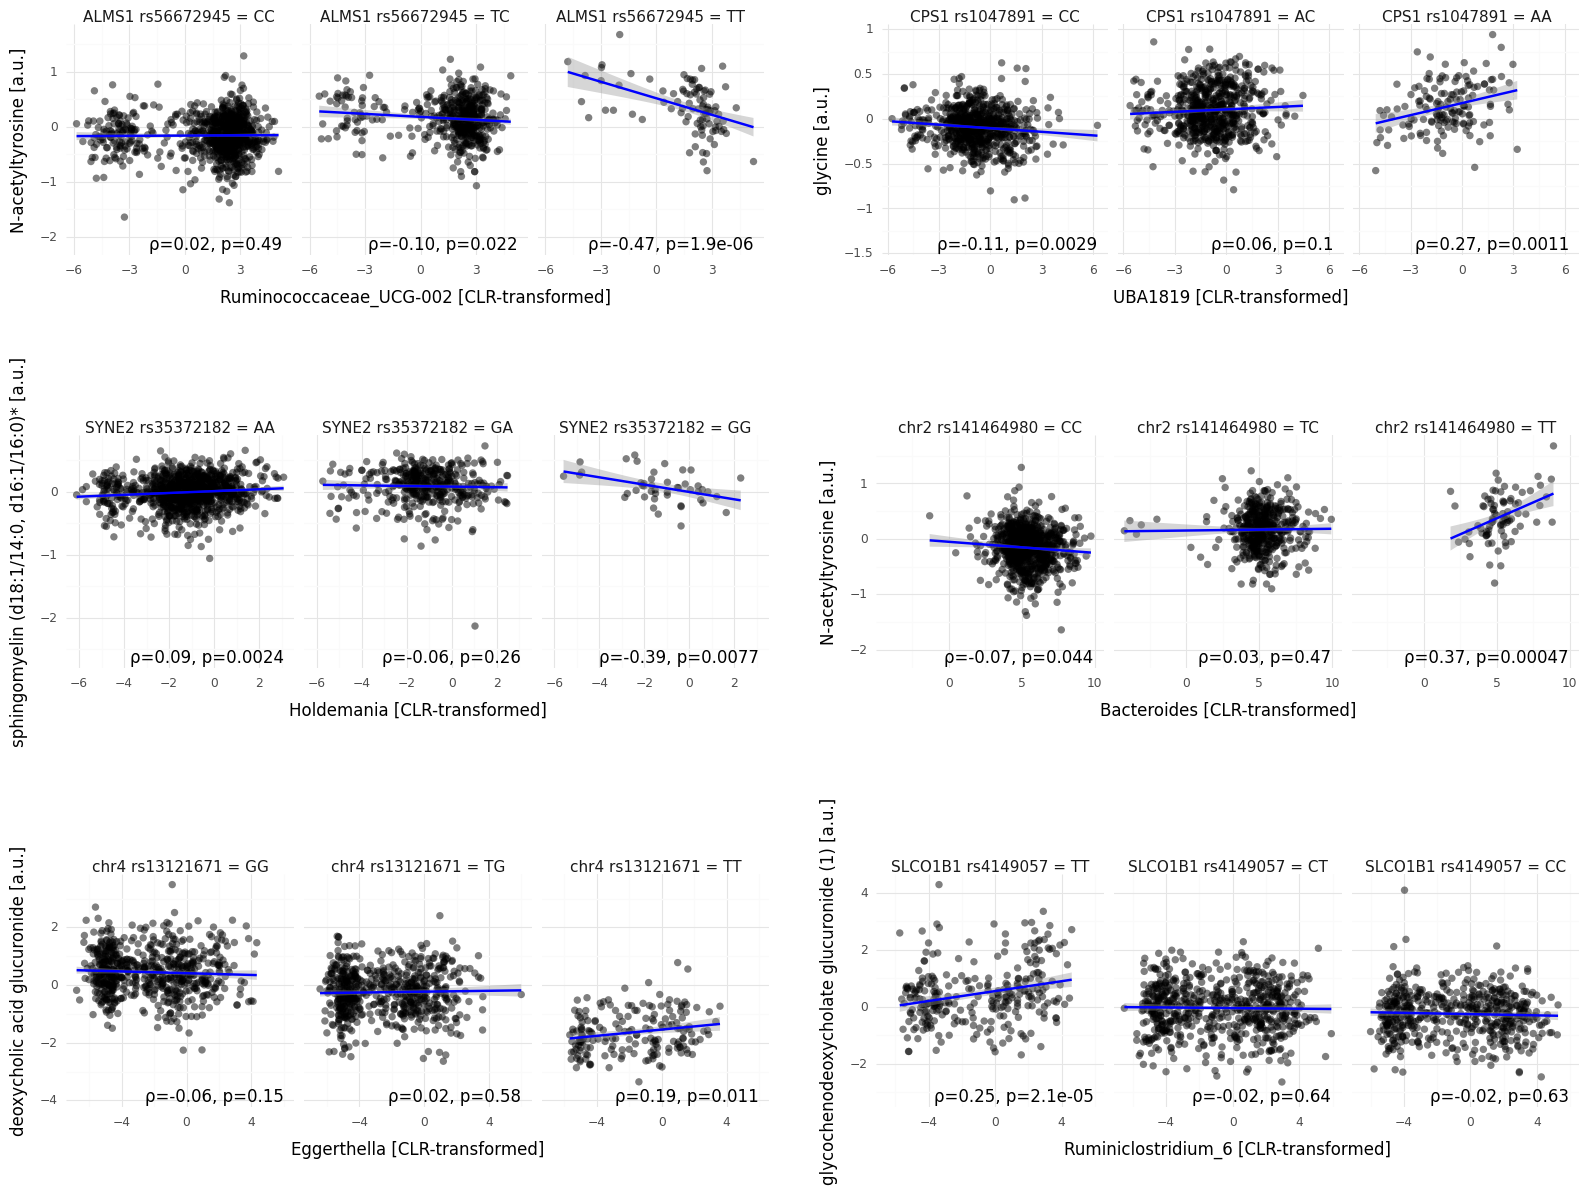

In [34]:
unadj = []

for i in [0, 1, 11, 14]:
    pl = plot_interaction(interactions.iloc[i], raw, prefix="unadjusted|")
    unadj.append(pw.load_ggplot(pl, figsize=size))

pl = plot_interaction(interactions[
    (interactions.genus == "Eggerthella") 
    & (interactions.BIOCHEMICAL_NAME == "deoxycholic acid glucuronide")
    ].iloc[0], raw, prefix="unadjusted|")
unadj.append(pw.load_ggplot(pl, figsize=size))

pl = plot_interaction(
    interactions[
        interactions.BIOCHEMICAL_NAME.str.startswith("glycocheno")
    ].iloc[0], raw, prefix="unadjusted|")
unadj.append(pw.load_ggplot(pl, figsize=size))

((unadj[0] | unadj[1]) / (unadj[2] | unadj[3]) / (unadj[4] | unadj[5])).savefig("figures/unadjusted_interactions.pdf")

---

Here we check one interaction from the preprint.

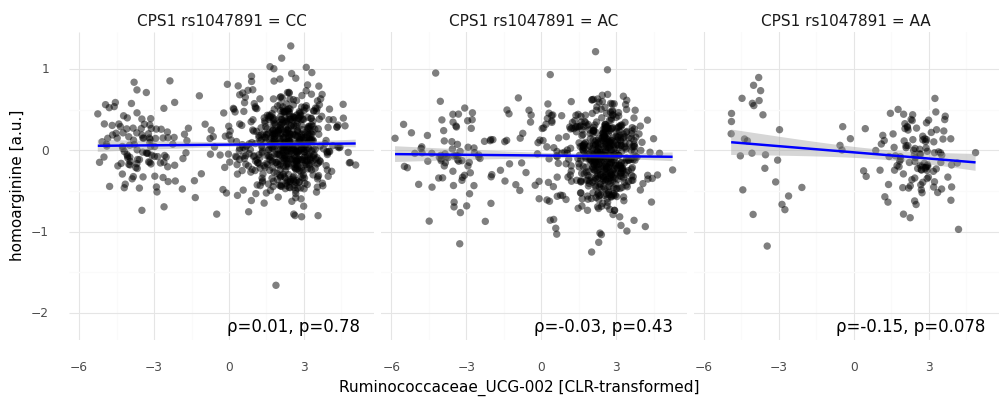

<ggplot: (8776075497915)>

In [38]:
ha = pd.DataFrame({
    "taxon": "Ruminococcaceae|Ruminococcaceae_UCG-002", 
    "genus": "Ruminococcaceae_UCG-002", 
    "metabolite": "metabolite_100000961", 
    "SNP": "rs1047891", 
    "rsid": "rs1047891", 
    "genes": "CPS1",
    "BIOCHEMICAL_NAME": "homoarginine"
}, index=[0])
plot_interaction(ha.iloc[0], metabolites) + theme(figure_size=(12, 4))